clean data

In [37]:
import numpy as np
import pandas as pd

def NASDAQ_csv_input(file_name, file_path, start_train: int, end_train: int,
                     start_test: int, end_test: int):
    """
    Converts NASDAQ stock csv files to pd.dataframe with dtypes 
    [Datetime, np.float32, np.float32, np.float32, np.float32, np.int32] 
    in ascending order.
    Parameters:
    file_name: string name of full file name
    file_path: string name of full path to file
    Returns:
    pd.dataframe
    """
    # Import File
    ohlcv_data = pd.read_csv(f'{file_path}/{file_name}').iloc[::-1].reset_index(drop=True)

    # Updating Column names and order
    column_names_mapping = {'Date':'date',
                            'Close/Last':'close',
                            'Volume':'volume',
                            'Open':'open',
                            'High':'high',
                            'Low':'low'}
    desired_order = ['date','open','high','low','close','volume']
    ohlcv_data = ohlcv_data.rename(columns=column_names_mapping)[desired_order]

    # Converting to Date String to datetime datatype
    ohlcv_data['date'] = pd.to_datetime(ohlcv_data['date'], format='%m/%d/%Y')

    # Converting currency columns to float32 datatype
    columns_with_dollars = [col for col in column_names_mapping.values() if col not in ['date','volume']]
    for col in columns_with_dollars:
        ohlcv_data[col] = ohlcv_data[col].str.replace('$', '').astype(np.float32)

    # Converting 'volume' column to int32 datatype
    ohlcv_data['volume'] = ohlcv_data['volume'].astype(np.int32)

    ohlcv_data_train = ohlcv_data[start_train:end_train]
    ohlcv_data_test = ohlcv_data[start_test:end_test]


    return ohlcv_data, ohlcv_data_train, ohlcv_data_test


DQN Agent data load

In [38]:
import sys
pwd = r"C:\Users\augus\OneDrive\Desktop\rl_stock_agents"
sys.path.append(pwd)


#stock_list =["amzn_daily.csv"] # "appl_daily.csv","tsla_daily.csv","f_daily.csv","pfe_daily.csv","coke_daily.csv","brk_daily.csv","nee_daily.csv","jnj_daily.csv","pg_daily.csv"]

file_name = 'amzn_daily.csv'#,'APPL','TSLA','F','PFE','COKE','BRK','NEE','JNJ','PG']

import_path = r"C:\Users\augus\OneDrive\Desktop\rl_stock_agents\input_data"

start_train, end_train, start_test, end_test = 0, 2000, 2000, 2517

# Import File
ohlcv_data, ohlcv_data_train, ohlcv_data_test = NASDAQ_csv_input(file_name,import_path,start_train, end_train, start_test, end_test)

C:\Users\augus\AppData\Local\Temp\ipykernel_35288\3620262999.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ohlcv_data[col] = ohlcv_data[col].str.replace('$', '').astype(np.float32)


Environment

In [54]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class ContinuousOHLCVEnv(gym.Env):
    def __init__(self, ohlcv_data, initial_cash=1000):
        self.ohlcv_raw_data = ohlcv_data
        self.initial_cash = initial_cash
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,))
        self.max_idx = ohlcv_data.shape[0] - 1
        self.reset()

    def reset(self):
        self.current_step = 0
        self.cash_in_hand = self.initial_cash
        self.stock_holding = 0
        self.step_info = []  # Initialize an empty list to store step information
        self.stock_price = self.ohlcv_raw_data[self.current_step][3]  # Assuming closing price for stock price
        self.total_portfolio_value = self.cash_in_hand + (self.stock_holding * self.stock_price)
        self.available_actions = (0, 1)  # Can hold or buy initially
        return self.get_observation()
    
    def step(self, action):
        assert self.action_space.contains(action), f'Action {action} not in action space'

        prev_valuation = self.total_portfolio_value

        if action == 1:  # Buy
            self._buy()
        elif action == 2:  # Sell
            self._sell()

        # Update portfolio value
        self.total_portfolio_value = self.cash_in_hand + (self.stock_holding * self.stock_price)
        reward = self.total_portfolio_value - prev_valuation
        done = self.current_step >= (len(self.ohlcv_raw_data) - 1)

        step_data = {
            'Step': self.current_step,
            'Portfolio Value': np.round(self.total_portfolio_value, 2),
            'Cash': np.round(self.cash_in_hand, 2),
            'Stock Value': np.round(self.stock_price * self.stock_holding, 2), 
            'Stock Holdings': np.round(self.stock_holding, 0),
            'Stock Price': np.round(self.stock_price, 2),
            'Available Actions': self.available_actions,
            'Action': action
        }
        self.step_info.append(step_data)

        if not done:
            self.current_step += 1
            self.stock_price = self.ohlcv_raw_data[self.current_step][3]

        # Update available actions
        if self.stock_holding > 0:
            self.available_actions = (0, 2)  # Can hold or sell
        else:
            self.available_actions = (0, 1)  # Can hold or buy

        next_observation = self.get_observation()
        info = {'available_actions': self.available_actions}
        return next_observation, reward, done, info
    
    def _buy(self):
        self.num_stocks_buy = np.floor(self.cash_in_hand/self.stock_price) # Buy 
        #Maximum allowed (Current Method)
        self.cash_in_hand -= self.num_stocks_buy * self.stock_price
        self.stock_holding = self.num_stocks_buy
        self.num_stocks_buy = 0
        self.available_actions = (-1,0)
        return
    
    def _sell(self):
        self.num_stocks_sell = self.stock_holding # Sell all stocks (Current Mehtod)
        self.cash_in_hand += self.num_stocks_sell * self.stock_price  # No commission
        #fee can be added later
        self.stock_holding -= self.num_stocks_sell
        self.num_stocks_sell = 0
        self.available_actions = (0,1)
        return
 
    def get_observation(self):
        return self.ohlcv_raw_data[self.current_step, :].astype(np.float32)

    def get_step_data(self):
        return pd.DataFrame(self.step_info)  # Generate a DataFrame from stored 
    #step information

DQN Agent

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import time
import random

class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_dqn(env):
    print("\t".join(["epoch", "epsilon", "total_step", "log_reward", "log_loss", "elapsed_time", "total financial return"]))

    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    hidden_size = 100

    Q = QNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    Q_ast = copy.deepcopy(Q)
    optimizer = optim.Adam(Q.parameters())

    # Hyperparameters
    epoch_num = 50
    step_max = len(env.ohlcv_raw_data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 50
    update_q_freq = 90
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    return_dqn = 0

    start = time.time()
    for epoch in range(epoch_num):
        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:
            # Select action
            if np.random.rand() > epsilon:
                pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32)).unsqueeze(0)).detach()
                pact = pact.max(1)[1].item()
            else:
                pact = env.action_space.sample()

            # Act
            obs, reward, done, _ = env.step(pact)

            # Add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # Train or update Q
            if len(memory) == memory_size and total_step % train_freq == 0:
                mini_batch = random.sample(memory, batch_size)
                b_pobs = torch.from_numpy(np.array([item[0] for item in mini_batch], dtype=np.float32))
                b_pact = torch.from_numpy(np.array([item[1] for item in mini_batch], dtype=np.int64))
                b_reward = torch.from_numpy(np.array([item[2] for item in mini_batch], dtype=np.float32))
                b_obs = torch.from_numpy(np.array([item[3] for item in mini_batch], dtype=np.float32))
                b_done = torch.from_numpy(np.array([item[4] for item in mini_batch], dtype=bool))

                q = Q(b_pobs)
                maxq = Q_ast(b_obs).detach().max(1)[0]
                target = q.clone()
                for i in range(batch_size):
                    target[i, b_pact[i]] = b_reward[i] + gamma * maxq[i] * (not b_done[i])

                # Loss and optimize
                optimizer.zero_grad()
                loss = nn.functional.mse_loss(q, target)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            # Update Q_ast
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)

            # Epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # Next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        # Logging
        #########################Adjust th statistics, not sure they are logical###
        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):]) / show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):]) / show_log_freq
            elapsed_time = time.time() - start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()

    final_return = sum(total_rewards)
    print(f"final return : {final_return}")

    return Q, total_losses, total_rewards, final_return

train

In [56]:
env = ContinuousOHLCVEnv(ohlcv_data_train[["open","high","low",'close',"volume"]].to_numpy())  # You need to provide the ohlcv_data
Q, losses, rewards, final_return = train_dqn(env)


epoch	epsilon	total_step	log_reward	log_loss	elapsed_time	total financial return
5	0.0999999999999992	9995	-991.4954389572143	44374999868152.14	1.5124430656433105
10	0.0999999999999992	19990	-993.194197845459	19180707.29388962	1.5145666599273682
15	0.0999999999999992	29985	-996.847564125061	5083.397662879526	1.4441184997558594
20	0.0999999999999992	39980	-999.575044631958	3383.2122622422876	1.55234956741333
25	0.0999999999999992	49975	-996.9500362396241	10320.753411709517	1.4822533130645752
30	0.0999999999999992	59970	-995.3963809967041	3421.6627893060445	1.5188028812408447
35	0.0999999999999992	69965	-995.5682916641235	7776714.620336783	1.6528940200805664
40	0.0999999999999992	79960	-998.736429977417	51968729.47056961	1.5503206253051758
45	0.0999999999999992	89955	-999.5622226715088	141487493.84609374	1.3984417915344238
50	0.0999999999999992	99950	-997.8931104660035	5757319779457.777	1.40358304977417
final return : -49826.093587875366


# Test

In [57]:
def test_dqn(env, model, num_episodes=100):
    """
    Test the DQN model on the environment.

    Parameters:
    env (gym.Env): The trading environment instance.
    model (QNetwork): The trained DQN model.
    num_episodes (int): Number of episodes to run the test.

    Returns:
    list: Rewards obtained in each episode.
    """
    total_rewards = []  # Store rewards for each episode

    for episode in range(num_episodes):
        observation = env.reset()  # Reset the environment for a new episode
        done = False
        total_reward = 0

        while not done:
            print("Observation type:", type(observation))  # Debugging line
            print("Observation shape:", observation.shape)  # Debugging line
            # Select action based on the model's prediction
            with torch.no_grad():
                action = model(torch.from_numpy(observation.astype(np.float32)).unsqueeze(0))
            action = action.max(1)[1].item()

            # Take the action and observe the next state and reward
            observation, reward, done, _ = env.step(action)

            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards

In [61]:
#AM NOT CONVICED ITS CORRECT NEEED TO SEE IF FOR REAL WE TESTING 500 DATA POINTS
#CHANGE THE STATISTICS, MAKE SURE THEY ARE NOT SUMMING ALL INTO ONE
#MAYBE EXPORT TO EXCEL TO SEE STEP DATA, CHECK ALL THE MEANINGS OF EPOCHS, EPISODES ETC
print(ohlcv_data_test[["open", "high", "low", 'close', "volume"]])
print(ohlcv_data_train[["open", "high", "low", 'close', "volume"]])
# Training the model
env_train = ContinuousOHLCVEnv(ohlcv_data_train[["open", "high", "low", 'close', "volume"]].to_numpy())
trained_model, _, _, _ = train_dqn(env_train)

# Testing the trained model
env_test = ContinuousOHLCVEnv(ohlcv_data_test[["open", "high", "low", 'close', "volume"]].to_numpy())
total_rewards = test_dqn(env_test, model=trained_model, num_episodes=100)


# Analyze test performance
average_reward = sum(total_rewards) / len(total_rewards)
print(f"Average reward over {len(total_rewards)} episodes: {average_reward}")


            open        high         low       close    volume
2000  176.150497  177.179993  174.750504  176.158005  45253660
2001  175.750000  176.969498  174.139496  174.171005  46061820
2002  175.417007  175.927002  170.500000  172.212006  60689760
2003  172.000000  172.100006  169.130005  169.567505  62169000
2004  167.550003  169.498993  166.440002  169.091507  55975280
...          ...         ...         ...         ...       ...
2512  153.300003  153.970001  152.100006  153.839996  36305730
2513  153.770004  154.350006  152.710007  153.419998  29514090
2514  153.559998  153.975006  153.029999  153.410004  25067220
2515  153.559998  154.779999  153.119995  153.339996  31434730
2516  153.720001  154.080002  152.949997  153.380005  27057000

[517 rows x 5 columns]
            open        high         low       close    volume
0      19.970501   19.996000   19.622499   19.668501  49706920
1      19.729000   19.941500   19.690001   19.939501  39921780
2      19.940001   19.968000   

Agent performance

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def agent_stock_performance(stock_price_ts: np.ndarray, trade_ts: np.ndarray, stock_name: str, agent_name: str):
    buy_price_idx = np.where(trade_ts == 1)[0]
    sell_price_idx = np.where(trade_ts == 2)[0]

    # Ensure the lengths of buy and sell indices are equal for comparison
    min_length = min(len(buy_price_idx), len(sell_price_idx))
    buy_price_idx = buy_price_idx[:min_length]
    sell_price_idx = sell_price_idx[:min_length]

    # Proceed with the calculations
    buy_price = stock_price_ts[buy_price_idx]
    sell_price = stock_price_ts[sell_price_idx]
    fig, ax = plt.subplots()
    ax.plot(stock_price_ts, color='grey')
    ax.scatter(buy_price_idx, buy_price, color='g', marker="^")
    ax.scatter(sell_price_idx, sell_price, color='r', marker="v")

    trade_wins = np.sum(stock_price_ts[buy_price_idx] < stock_price_ts[sell_price_idx])
    trade_loss = np.sum(stock_price_ts[buy_price_idx] > stock_price_ts[sell_price_idx])
    trade_total = min_length

    # Calculate Rate of Return (ROR) per trade
    ror_per_trade = stock_price_ts[sell_price_idx] / stock_price_ts[buy_price_idx]
    trade_return = np.prod(ror_per_trade)
    win_percentage = (trade_wins / trade_total) * 100 if trade_total > 0 else 0

    # Highlighting Buy-Sell periods
    for start, end in zip(buy_price_idx, sell_price_idx):
        color = 'grey' if stock_price_ts[start] == stock_price_ts[end] else ('g' if stock_price_ts[start] < stock_price_ts[end] else 'r')
        ax.axvspan(start, end, color=color, alpha=0.15)

    plt.title(f'{agent_name} Agent: {stock_name} Trade Performance')
    plt.ylabel(f'{stock_name} Price')
    plt.xlabel('Time Step')

    plotbox_x = 10
    plotbox_y = np.median(stock_price_ts) - (min(stock_price_ts) / 4.75)

    textbox_content = (f"Trades: {trade_total:>5}\n"
                       f"Wins: {trade_wins:>8}\n"
                       f"Loss: {trade_loss:>8}\n"
                       f"Win %: {win_percentage:.2f}\n"
                       f"ROR: {trade_return:.3f}")

    ax.text(plotbox_x, plotbox_y, textbox_content, bbox=dict(facecolor='yellow', alpha=0.5), 
            horizontalalignment='left', verticalalignment='bottom', fontsize=8)

    plt.show()

    results = {"n_trades": trade_total, 
               "n_wins": trade_wins, 
               "n_losses": trade_loss, 
               "win_percentage": win_percentage, 
               "ror": trade_return}

    return results

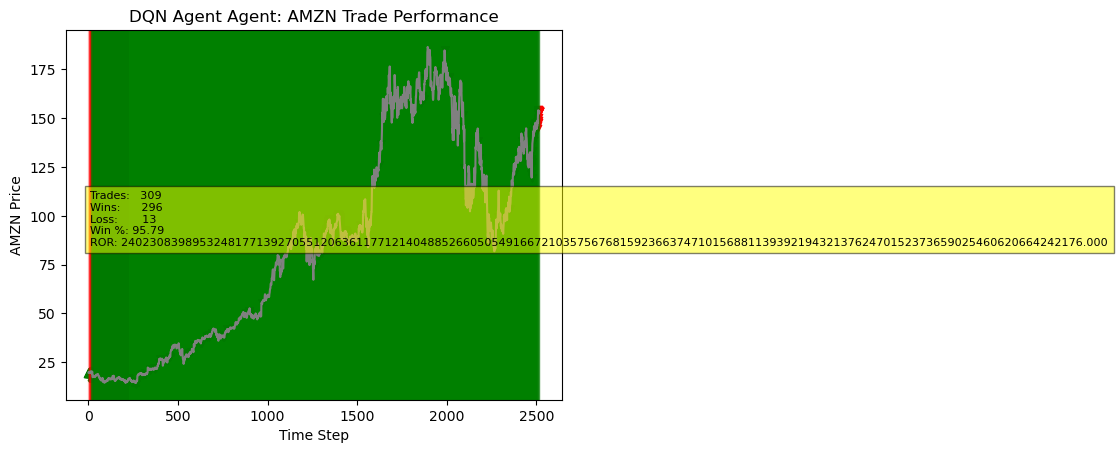

In [9]:
# Assuming `env` is your trading environment instance after DQN run
step_data = env.get_step_data()  # Extract the DataFrame from step_info

# Extract actions and stock prices
actions_taken = step_data['Action'].to_numpy()
stock_prices = step_data['Stock Price'].to_numpy()

# Analyze performance
performance_results = agent_stock_performance(
    stock_price_ts=stock_prices,
    trade_ts=actions_taken,
    stock_name="AMZN",
    agent_name="DQN Agent"
)

In [ ]:




###########################################################

#DQN Agent
import sys
pwd = "P:/dsv/DAMII/Practical Project/rl_stock_agents"
sys.path.append(pwd)

import cleandata
import numpy as np
from stockenv import ContinuousOHLCVEnv
import matplotlib.pyplot as plt
from agentperform import agent_stock_performance
from agents import DQNAgent
import logging



stock_list =["amzn_daily.csv"]#, "appl_daily.csv","tsla_daily.csv","f_daily.csv","pfe_daily.csv",
             #"coke_daily.csv","brk_daily.csv","nee_daily.csv","jnj_daily.csv","pg_daily.csv"]

stock_name_list = ['AMZN']#,'APPL','TSLA','F','PFE','COKE','BRK','NEE','JNJ','PG']

import_path = "P:/dsv/DAMII/Practical Project/rl_stock_agents/input_data"


# Instantiate the environment

results =[]

for file_name, stock_name in zip(stock_list,stock_name_list):
    # Import File
    
    df_ohlcv = cleandata.NASDAQ_csv_input(file_name,import_path)


    env = ContinuousOHLCVEnv(df_ohlcv[["open","high","low",'close',"volume"]].iloc[:2000].to_numpy())


    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    available_actions = env.available_actions

    # Create a DQN agent
    agent = DQNAgent(state_size, action_size,available_actions)

    batch_size = 32
    EPISODES = 50  # Number of episodes for training

    for e in range(EPISODES):
        logging.info(e)
        env.reset()
        state = env.get_observation()
        state = np.reshape(state, [1, state_size])
        print(available_actions)
        for time in range(500):  # Adjust the number of time steps per episode
            action, action_type = agent.act(state)
            next_state, reward, new_available_actions, done = env.step(action)
            logging.info(action_type)
            logging.info(env.step_info[-1])
            agent.available_actions = new_available_actions
            reward = reward if not done else -10  # Modify the reward as needed
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(f"episode: {e}/{EPISODES}, score: {time}, epsilon: {agent.epsilon:.2}")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

+++++++++++++++++++++++++++++++++


In [ ]:
Stock performance plots
import matplotlib.pyplot as plt
import numpy as np

def agent_stock_performance(stock_price_ts: np.ndarray, trade_ts: np.ndarray,stock_name: str, agent_name:str):
    # ---------------------------------------------------------------------------------------------
    # Converts NASDAQ stock csv files from https://www.nasdaq.com/market-activity/quotes/historical
    # to pd.dataframe[date, open, high, low, close, volume] 
    # with dtypes[Datetime,np.float32, np.float32, np.float32, np.float32, np.float32, np.int)
    # in ascentding order
    #----------------------------------------------------------------------------------------------
    ## Parameters:
    #-----------------------------------------------------------------------------------------------
    #   stock_price_ts: (np.narray) 
    #       1-D array with stock's price at each timestep 
    #   trade_ts: (np.narray)
    #       1-D array with agent's action at each time step. Action defined as [-1,0,1] as
    #       [Sell, Hold, Buy] respectively.  
    #   stock_name: (str)
    #       Name of stock, for labeling of plot
    #   agent_name: (str)
    #       Name of agent, for labeling of plot
    #----------------------------------------------------------------------------------------------
    # Returns:
    #----------------------------------------------------------------------------------------------
    #   dict: dict.keys=["n_trades", "n_wins", "n_losses", "win_percentage", "ror"]
    #       dictionary with agent's trade performance:
    #           - number of trades
    #           - number of winning trades
    #           - number losing trades
    #           - trade win percentage
    #           - rate of return (product of all conducted trade returns)
    # ----------------------------------------------------------------------------------------------  

        
    # Finding index and stock price of Buy Action
    buy_price_idx = np.where(trade_ts == 'B')[0]
    buy_price_idx = buy_price_idx.astype(int)
    buy_price = stock_price_ts[buy_price_idx]

    # Finding index and stock price of Sell Action
    sell_price_idx = np.where(trade_ts == 'S')[0]
    sell_price_idx = sell_price_idx.astype(int)
    sell_price = stock_price_ts[sell_price_idx]

    # Ploting Stock Price and locations of Buy and Sell Actions
    fig, ax = plt.subplots()
    ax.plot(stock_price_ts, color='grey')
    ax.scatter(buy_price_idx,buy_price,color='g',marker="^")
    ax.scatter(sell_price_idx,sell_price,color='r',marker="v")

    # Calculating Win, Loss, Total Trades
    trade_wins = np.sum(stock_price_ts[buy_price_idx] < stock_price_ts[sell_price_idx])
    trade_loss = np.sum(stock_price_ts[buy_price_idx] > stock_price_ts[sell_price_idx])
    trade_total = int((len(buy_price_idx) + len(sell_price_idx))/2) #Function assumes trade_ts has proper buy-sell patterns 
    trade_return = np.prod(stock_price_ts[sell_price_idx] / stock_price_ts[buy_price_idx])
    win_precentage = trade_wins/trade_total*100
    
    ror_per_tradeframe = []
    assert len(buy_price_idx) == len(sell_price_idx), "Arrays should have the same length"
    buy_sell_len = len(buy_price_idx)
    for idx in range(buy_sell_len):
        sell_idx = sell_price_idx[idx]
        buy_idx = buy_price_idx[idx]
        assert buy_idx < sell_idx, "Buy time index should occur before sell time index"
        if idx > 0:
            last_buy_idx = buy_price_idx[idx - 1]
            last_sell_idx = sell_price_idx[idx - 1]
            assert sell_idx > last_buy_idx, "Sell time index should occur before last buy time index"
            assert buy_idx > last_sell_idx, "Buy time index should occur after last buy time index"        
        ror = stock_price_ts[sell_idx] / stock_price_ts[buy_idx]
        ror_per_tradeframe.append(ror)

    trade_return = np.prod(ror_per_tradeframe)
    
    hl_start = np.where(trade_ts == 'B')[0]
    hl_end = np.where(trade_ts == 'S')[0]

    for start, end in zip(hl_start, hl_end):
        color = 'grey' if stock_price_ts[start] == stock_price_ts[end] else ('g' if stock_price_ts[start] < stock_price_ts[end] else 'r')
        plt.axvspan(start, end, color=color, alpha=0.15)

    plt.title(f'{agent_name} Agent: {stock_name} Trade Performance')
    plt.ylabel(f'{stock_name} Price')
    plt.xlabel('Time Step')
    
    plotbox_x = 10
    plotbox_y = np.median(stock_price_ts) - (min(stock_price_ts)/4.75) 
        
    texbox_content = (f"Trades:{trade_total:>5}\n"
        f"Wins:{trade_wins:>8}\n"
        f"Loss: {trade_loss:>8}\n"
        f"Win %: {win_precentage:.2f}\n"
        f"ROR: {trade_return:.3f}"
    )
    ax.text(plotbox_x,
            plotbox_y,
            texbox_content, 
            bbox=dict(facecolor='yellow', alpha=0.5),
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=8)      
    plt.show()
    
    results = {"n_trades": trade_total, 
               "n_wins": trade_wins, 
               "n_losses": trade_loss, 
               "win_percentage":win_precentage, 
               "ror":trade_return}

    return results
